In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import re


e:\Project\FND_new\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Load the datasets
true_news = pd.read_csv('./real_stances.csv')
fake_news = pd.read_csv('./fake_stances.csv')

# Add labels
true_news['label'] = 1 
fake_news['label'] = 0

print(true_news.head())
print(fake_news.head())

                                            Headline  Body ID  label
0  Hundreds of Palestinians flee floods in Gaza a...      158      1
1  'Nasa Confirms Earth Will Experience 6 Days of...      154      1
2  Banksy 'Arrested & Real Identity Revealed' Is ...     1739      1
3                                     Gateway Pundit     2327      1
4  Woman detained in Lebanon is not al-Baghdadi's...     1468      1
                                            Headline  Body ID  label
0  Police find mass graves with at least '15 bodi...      712      0
1  Christian Bale passes on role of Steve Jobs, a...      137      0
2  HBO and Apple in Talks for $15/Month Apple TV ...     1034      0
3  Spider burrowed through tourist's stomach and ...     1923      0
4  Accused Boston Marathon Bomber Severely Injure...      962      0


In [5]:
# # Concatenate the datasets
# data = pd.concat([true_news, fake_news], ignore_index=True)
# print(data.info())
data=pd.read_csv('./merged1.csv')
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49972 non-null  object
 1   Body ID      49972 non-null  int64 
 2   articleBody  49972 non-null  object
 3   label        49972 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB
None


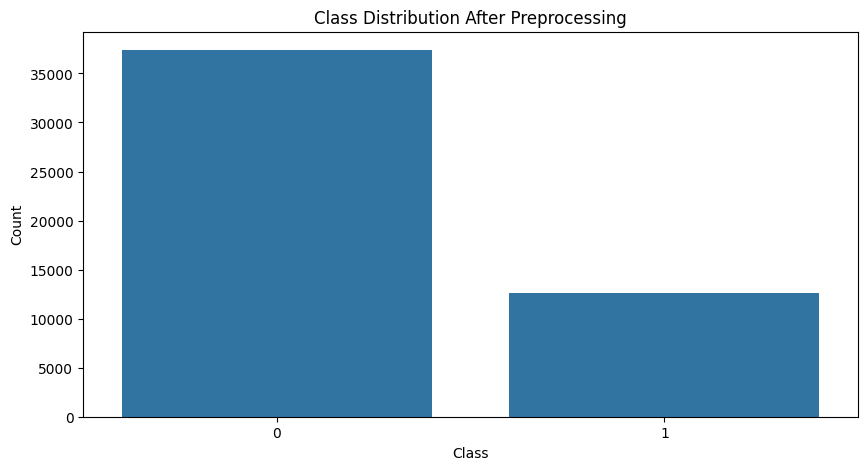

In [6]:

# Drop unnecessary columns
# data = data.drop(['date', 'subject'], axis=1)
data = data.drop(['Body ID'], axis=1)

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Function to clean text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    return text

# Apply preprocessing to title and text
data['Headline'] = data['Headline'].apply(preprocess_text)
data['articleBody'] = data['articleBody'].apply(preprocess_text)

# Create 'combined_text'
data['combined_text'] = data['Headline'] + ' ' + data['articleBody']

# Visualize class distribution after preprocessing
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=data)
plt.title('Class Distribution After Preprocessing')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [7]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize the text using DistilBERT's tokenizer
def tokenize_text(text):
    return tokenizer(text.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=256)

# Tokenize the combined text
tokenized_data = tokenize_text(data['combined_text'])

# Split the data into features and labels
X = tokenized_data['input_ids']
y = data['label'].values

# Convert Tensors to numpy arrays
X_numpy = X.numpy()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y, test_size=0.3, random_state=42)

# Apply resampling to the training set
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


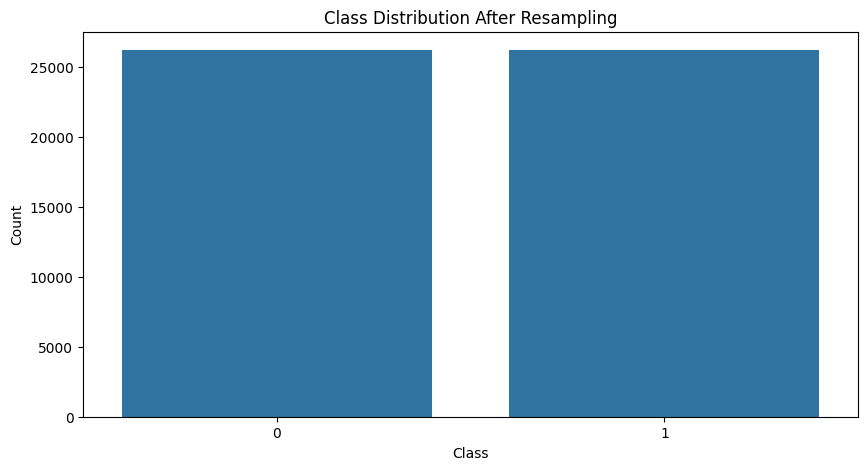

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [9]:
# Define the model
input_ids = Input(shape=(256,), dtype=tf.int32, name="input_ids")
distilbert_output = distilbert_model(input_ids)[0]  # The output from DistilBERT

# Add a dropout layer
dropout = Dropout(0.3)(distilbert_output[:, 0, :])  # Use the CLS token's output
output = Dense(1, activation='sigmoid')(dropout)  # Binary classification

# Build and compile the model
model = Model(inputs=input_ids, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 256)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 256,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout_19 (Dropout)        (None, 768)               0         
                                                             

In [10]:
# Define a callback to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model_distilbert.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=5,  # Use more epochs if necessary
    batch_size=4,
    callbacks=[checkpoint]
)

Epoch 1/5
 1806/13095 [===>..........................] - ETA: 27:42 - loss: 0.7305 - accuracy: 0.5069

ResourceExhaustedError: Graph execution error:

Detected at node 'model/tf_distil_bert_model/distilbert/transformer/layer_._5/ffn/Gelu/mul_1' defined at (most recent call last):
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "e:\Project\FND_new\myenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "e:\Project\FND_new\myenv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\k7adi\AppData\Local\Temp\ipykernel_21244\1576163203.py", line 6, in <module>
      history = model.fit(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\modeling_tf_utils.py", line 601, in run_call_with_unpacked_inputs
      del cast_output
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 602, in call
      outputs = self.distilbert(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\modeling_tf_utils.py", line 601, in run_call_with_unpacked_inputs
      del cast_output
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 455, in call
      tfmr_output = self.transformer(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 358, in call
      for i, layer_module in enumerate(self.layer):
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 362, in call
      layer_outputs = layer_module(hidden_state, attn_mask, head_mask[i], output_attentions, training=training)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 302, in call
      ffn_output = self.ffn(sa_output, training=training)  # (bs, seq_length, dim)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 244, in call
      x = self.activation(x)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\activations.py", line 359, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'model/tf_distil_bert_model/distilbert/transformer/layer_._5/ffn/Gelu/mul_1'
failed to allocate memory
	 [[{{node model/tf_distil_bert_model/distilbert/transformer/layer_._5/ffn/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13145]

In [20]:

# Load the best model
best_model = tf.keras.models.load_model('best_model_distilbert.h5', custom_objects={"TFDistilBertModel": TFDistilBertModel})

# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

469/469 [==============================] - 41s 79ms/step - loss: 0.2314 - accuracy: 0.9015
Test Loss: 0.23140300810337067
Test Accuracy: 0.9014807939529419
469/469 [==============================] - 37s 76ms/step
Confusion Matrix:
[[10249   947]
 [  530  3266]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     11196
           1       0.78      0.86      0.82      3796

    accuracy                           0.90     14992
   macro avg       0.86      0.89      0.87     14992
weighted avg       0.91      0.90      0.90     14992



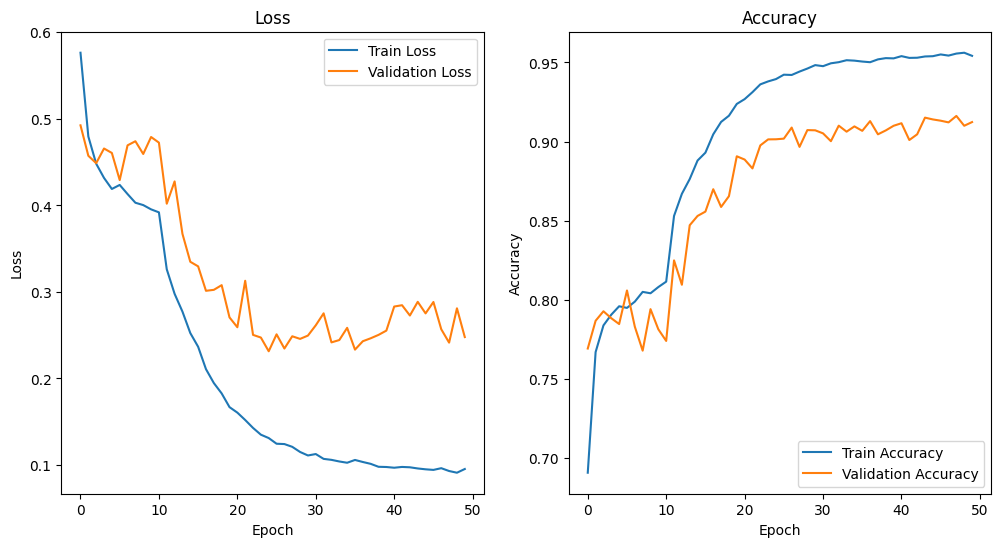

In [21]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()